In [22]:
# Initial imports
import numpy as np
import pandas as pd
from statistics import mean, mode
import matplotlib.pyplot as plt

from pathlib import Path
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, cross_validate


In [23]:
# Loading data
file_path = Path("../eda/reduced_filtered_df.csv")
df = pd.read_csv(file_path)
df.head(5)

,ACD,LT,VCD,SPORTHR,DADMY,delta_spheq,total_positive_screen,MYOPIC
0,3.702,3.392,15.29,4,1,1.358,8,0
1,3.462,3.514,15.52,14,0,1.929,10,0
2,3.224,3.556,15.36,10,1,2.494,26,0
3,3.186,3.654,15.49,12,1,1.433,16,0
4,3.732,3.584,15.08,12,0,2.022,8,0


In [24]:
# Check dataset balance
df["MYOPIC"].value_counts()

0    323
1     49
Name: MYOPIC, dtype: int64

In [25]:
# Check dataset balance
df["MYOPIC"].value_counts(normalize=True)

0    0.86828
1    0.13172
Name: MYOPIC, dtype: float64

In [26]:
# Define X,y
label = df["MYOPIC"]
X = df.iloc[:,:-1].copy()
X.head()

,ACD,LT,VCD,SPORTHR,DADMY,delta_spheq,total_positive_screen
0,3.702,3.392,15.29,4,1,1.358,8
1,3.462,3.514,15.52,14,0,1.929,10
2,3.224,3.556,15.36,10,1,2.494,26
3,3.186,3.654,15.49,12,1,1.433,16
4,3.732,3.584,15.08,12,0,2.022,8


## KNN

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, label, 
    random_state=42, 
    stratify=label,
    train_size=200)

In [28]:
# Create a scaler to standardize the data
scaler = StandardScaler()

In [29]:
# Train the scaler with the X_train data.
scaler.fit(X_train)

StandardScaler()

In [30]:
# Transform X_train and X_test.
# Note that the scaler used to transform X_train and X_test was trained on X_train.
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Determine best k value

k: 1, Train/Test Score: 1.000/0.826
k: 3, Train/Test Score: 0.910/0.872
k: 5, Train/Test Score: 0.875/0.890
k: 7, Train/Test Score: 0.880/0.884
k: 9, Train/Test Score: 0.880/0.878
k: 11, Train/Test Score: 0.870/0.878
k: 13, Train/Test Score: 0.885/0.878
k: 15, Train/Test Score: 0.870/0.872
k: 17, Train/Test Score: 0.875/0.872
k: 19, Train/Test Score: 0.870/0.866


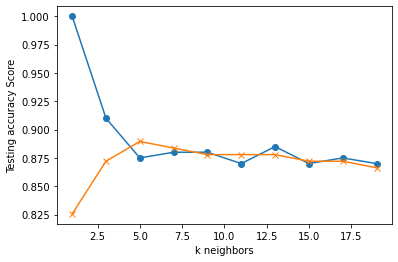

In [31]:
# Loop through different k values to find which has the highest accuracy.
# Note: We use only odd numbers because we don't want any ties.
train_scores = []
test_scores = []
for k in range(1, 20, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    train_score = knn.score(X_train_scaled, y_train)
    test_score = knn.score(X_test_scaled, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")
    
    
plt.plot(range(1, 20, 2), train_scores, marker='o')
plt.plot(range(1, 20, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy Score")
plt.show()

## Run best k value model

In [32]:
# Instantiate KNN model and make predictions
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)
accuracy_score(y_test, y_pred)

0.8895348837209303

In [33]:
confusion_matrix(y_test, y_pred)

array([[148,   1],
       [ 18,   5]], dtype=int64)

In [34]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.99      0.94       149
           1       0.83      0.22      0.34        23

    accuracy                           0.89       172
   macro avg       0.86      0.61      0.64       172
weighted avg       0.88      0.89      0.86       172



In [35]:
scoring = ('f1', 'recall', 'precision', 'roc_auc')
steps = [('scaler', StandardScaler()), ('model', KNeighborsClassifier(n_neighbors=5))]
pipeline = Pipeline(steps=steps)

# evaluate pipeline
# Note for imbalanced classification don't use k-fold cross-validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_validate(pipeline, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
print('Mean f1: %.3f' % mean(scores['test_f1']))
print('Mean recall: %.3f' % mean(scores['test_recall']))
print('Mean precision: %.3f' % mean(scores['test_precision']))
print('Mean ROC AUC: %.3f' % mean(scores['test_roc_auc']))
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(f"-----"*10)
print(classification_report(y_test, y_pred))

Mean f1: 0.119
Mean recall: 0.094
Mean precision: 0.192
Mean ROC AUC: 0.771
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       149
           1       0.83      0.22      0.34        23

    accuracy                           0.89       172
   macro avg       0.86      0.61      0.64       172
weighted avg       0.88      0.89      0.86       172



### Reality Check
Running a single test made the model look promising but due to the imbalance data and the size of the test dataset, the results are not very reliable.  When running the cross validation, the numbers are quite different and these are more believable.  

The model shows it will predict myopia 27% time correctly but it has a high number of false negatives.  

## KNN with Balanced Data

In [36]:
from imblearn.over_sampling import SMOTE
from collections import Counter

In [37]:
over = SMOTE(random_state=42)
x_over, y_over = over.fit_resample(X_train, y_train)

In [38]:
print('Original dataset shape', Counter(y_train))
print('Resample dataset shape', Counter(y_over))

Original dataset shape Counter({0: 174, 1: 26})
Resample dataset shape Counter({0: 174, 1: 174})


In [39]:
# Create a scaler to standardize the data
scaler = StandardScaler()

# Train the scaler with the X_train data.
scaler.fit(x_over)

# Transform X_train and X_test.
# Note that the scaler used to transform X_train and X_test was trained on X_train.
X_over_train_scaled = scaler.transform(x_over)
X_over_scaled = scaler.transform(X_test)

## Test for best k

k: 1, Train/Test Score: 1.000/0.709
k: 3, Train/Test Score: 0.928/0.622
k: 5, Train/Test Score: 0.902/0.593
k: 7, Train/Test Score: 0.865/0.541
k: 9, Train/Test Score: 0.862/0.512
k: 11, Train/Test Score: 0.851/0.512
k: 13, Train/Test Score: 0.842/0.500
k: 15, Train/Test Score: 0.825/0.529
k: 17, Train/Test Score: 0.828/0.529
k: 19, Train/Test Score: 0.810/0.517


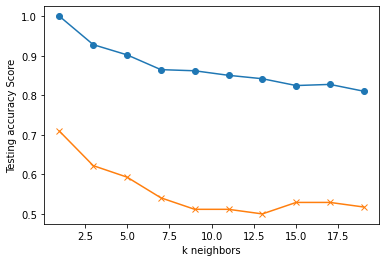

In [40]:
# Loop through different k values to find which has the highest accuracy.
# Note: We use only odd numbers because we don't want any ties.
train_scores = []
test_scores = []
for k in range(1, 20, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_over_train_scaled, y_over)
    train_score = knn.score(X_over_train_scaled, y_over)
    test_score = knn.score(X_test_scaled, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")
    
    
plt.plot(range(1, 20, 2), train_scores, marker='o')
plt.plot(range(1, 20, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy Score")
plt.show()

In [41]:
# Instantiate KNN model and make predictions
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_over_train_scaled, y_over)
y_pred = knn.predict(X_test_scaled)
print(f"Accuracy score: {accuracy_score(y_test, y_pred)}")
print(f"Confusion matrix:  {confusion_matrix(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy score: 0.5930232558139535
Confusion matrix:  [[84 65]
 [ 5 18]]
              precision    recall  f1-score   support

           0       0.94      0.56      0.71       149
           1       0.22      0.78      0.34        23

    accuracy                           0.59       172
   macro avg       0.58      0.67      0.52       172
weighted avg       0.85      0.59      0.66       172



## Validating results

In [42]:
scoring = ('f1', 'recall', 'precision', 'roc_auc')
steps = [('scaler', StandardScaler()), ('over', SMOTE(random_state=42)), ('model', KNeighborsClassifier(n_neighbors=5))]
pipeline = Pipeline(steps=steps)

# evaluate pipeline
# Note for imbalanced classification don't use k-fold cross-validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_validate(pipeline, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
print('Mean f1: %.3f' % mean(scores['test_f1']))
print('Mean recall: %.3f' % mean(scores['test_recall']))
print('Mean precision: %.3f' % mean(scores['test_precision']))
print('Mean ROC AUC: %.3f' % mean(scores['test_roc_auc']))
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(f"-----"*10)
print(classification_report(y_test, y_pred))

Mean f1: 0.380
Mean recall: 0.650
Mean precision: 0.279
Mean ROC AUC: 0.752
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.76      0.83       149
           1       0.28      0.61      0.38        23

    accuracy                           0.74       172
   macro avg       0.60      0.68      0.61       172
weighted avg       0.84      0.74      0.77       172



## Analysis
By balancing the data, the results did not change for the precision; it is still at about 25%.  The recall did improve so there are fewer false negatives predicted and but unfortunately the precision did not increase.  The model is probably better but a bit of a tradeoff since the previous false negatives were largely predicted to be a TP for every 3FP reclassified.  